# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [9]:
# Check the present working directory
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


### Download the data
If you do not have the required **data/** directory in your workspace, follow the instructions below. Use either one of the methods below. 

**Method 1** <br/>
You must [download this dataset](https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz) from the Downloads section in the classroom, and upload it into the workspace. After you upload the tar file to the present working  directory, **/workspace/cd1971 Data Scientist Capstone/Bertelsmann_Arvato Project Workspace/**,  in the Jupyter server, you can open a terminal and the run the following command to extract the dataset from the compressed file. 
```bash
!tar -xzvf arvato_data.tar.gz
```
This command will extract all the contents of arvato_data.tar.gz into the current directory. 

**Method 2** <br/>
Execute the Python code below to download the dataset. 


In [1]:
import requests
import tarfile
import os


def download_and_extract(url, extract_to='.'):
    """
    Downloads a tar.gz file from a URL and extracts it to a directory.
    Args:
    - url (str): URL of the tar.gz file to download.
    - extract_to (str): Directory path to extract the contents of the tar.gz file.
    """
    # Get the filename from the URL
    filename = url.split('/')[-1]

    # Download the file
    print("Downloading the file...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.raw.read())
        print("Download completed.")
    else:
        print("Failed to download the file.")
        return

    # Extract the tar.gz file
    print("Extracting the file...")
    try:
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print("Extraction completed.")
    except Exception as e:
        print(f"Failed to extract the file: {e}")
    finally:
        # Optionally remove the tar.gz file after extraction
        os.remove(filename)
        print("Downloaded tar.gz file removed.")

# URL of the tar.gz file
url = 'https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz'

# Call the function with the URL
download_and_extract(url)



Download completed.
Extracting the file...
Extraction completed.
Downloaded tar.gz file removed.



### Important Note
>Delete the **data/** folder and the downloaded tar file, before you submit your code. The current workspace cannot save the files beyond 1GB of space in total. 


### Import the Packages

In [13]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from math import pi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

# import arvato_functions
# import importlib
# importlib.reload(arvato_functions)
from arvato_functions import *

%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

>Note: If you experience "Kernel died" issue while running the codeblock below, then load less number of rows from the .csv files.

### Load Data

##### After the first pass of loading data directly from .csv files, we'll store all dataframes in a dictionary 'dfs' that we can pickle and load more easily going forward

In [134]:
# Read in datasets as chunks to prevent issues with kernel and save out as pickle to load more easily

# azdias = read_chunks(filepath='data/Udacity_AZDIAS_052018.csv',chunksize=10000,sep=';',low_memory=False)
# customers = read_chunks(filepath='data/Udacity_CUSTOMERS_052018.csv',chunksize=10000,sep=';',low_memory=False)
# mailout_train = read_chunks(filepath='data/Udacity_MAILOUT_052018_TRAIN.csv',chunksize=10000,sep=';',low_memory=False)
# mailout_test = read_chunks(filepath='data/Udacity_MAILOUT_052018_TEST.csv',chunksize=10000,sep=';',low_memory=False)

# Save pickle

# datasets = {
#     'azdias':azdias,
#     'customers':customers,
#     'mailout_train':mailout_train,
#     'mailout_test':mailout_test
# }

# with open('arvato_data.pkl','wb') as f:
#     pickle.dump(datasets,f)

In [135]:
# Load the dicitonary of dataframes from pickle and print basic information
with open('arvato_data.pkl', 'rb') as f:
    dfs = pickle.load(f)
    
# Print information
print(f'Datasets loaded: f{[key for key in dfs.keys()]}\n')
print('Information')
for name, df in dfs.items():
    print(f"{name} shape: {df.shape}")
    print(df.info(), "\n")

Datasets loaded: f['azdias', 'customers', 'mailout_train', 'mailout_test']

Information
azdias shape: (891221, 366)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
None 

customers shape: (191652, 369)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB
None 

mailout_train shape: (42962, 367)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB
None 

mailout_test shape: (42833, 366)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 1

##### <span style="color:#5A8CC8">We'll start with some basic work whittling down the datasets to a common set of features<span>

In [136]:
# First, we'll identify if there are any unique columns that aren't common across datasets
noncommon_cols(dfs)

azdias has 0 non-common columns.

customers has 3 non-common columns:
{'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'}

mailout_train has 1 non-common columns:
{'RESPONSE'}

mailout_test has 0 non-common columns.



In [137]:
# We want to keep "response", as this will be using this to evaluate model performance
# However, we can't use the three additional columns in customers since we don't have them for the target population, so we'll drop those
dfs['customers'] = dfs['customers'].drop(['ONLINE_PURCHASE', 'CUSTOMER_GROUP', 'PRODUCT_GROUP'],axis=1)

In [138]:
# NaNs are represented via codes for certain columns as outlined in 'DIAS Attributes - Values 2017.xlsx'
# We must impute these before settings a theshold for dropping NaN values
unknown_map = gen_unknown_map('DIAS Attributes - Values 2017.xlsx')

# Use map for unknown values to replace with NaNs in each df in dfs
for name, df in dfs.items():
    for attr, codes in unknown_map.items():
        # Only replace if the column is actually present in this dataframe
        if attr in df.columns: df[attr].replace(codes, np.nan, inplace=True)

In [139]:
# Remove any columns that are missing more than 20% of their data
dfs = missing_cols(dfs, threshold=30, remove=True)

Columns with >= 30% missing values (in at least one DataFrame):
['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KKK', 'KK_KUNDENTYP', 'REGIOTYP', 'TITEL_KZ'] 

Dropped 42 columns from 'azdias'. Now 324 columns remain.
Dropped 42 columns from 'customers'. No

##### <span style="color:#5A8CC8">Now, we'll summarize data types and perform any necessary imputations, such as encoding categorical variables<span>

In [140]:
# Summarize dataframe feature types
dtype_counts = dfs['customers'].dtypes.value_counts()
print("Feature Types Summary:")
for dtype, count in dtype_counts.items():
    print(f"  {dtype}: {count} columns")

Feature Types Summary:
  float64: 253 columns
  int64: 65 columns
  object: 6 columns


In [141]:
# We'll convert int64 to float64 
for name, df in dfs.items():
    int_cols = df.select_dtypes(include=['int64']).columns
    for col in int_cols:
        df[col] = df[col].astype('float64')

In [142]:
# An examine categorical variables
cats = dfs['customers'].select_dtypes(include=['object', 'category']).columns.tolist()
print('Unique Categories')
for cat in cats: print(f'{cat}: {dfs["customers"].loc[:,cat].nunique(dropna=True)}')
dfs['customers'].loc[:,cats]

Unique Categories
CAMEO_DEU_2015: 45
CAMEO_DEUG_2015: 10
CAMEO_INTL_2015: 22
D19_LETZTER_KAUF_BRANCHE: 35
EINGEFUEGT_AM: 3034
OST_WEST_KZ: 2


,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
191647,1C,1,14,D19_BANKEN_REST,1992-02-10 00:00:00,W
191648,5B,5,32,D19_UNBEKANNT,1997-03-06 00:00:00,W
191649,4D,4,24,D19_TECHNIK,1992-02-10 00:00:00,W
191650,4C,4,24,D19_BANKEN_REST,1992-02-10 00:00:00,W


In [143]:
# EINGEFUEGT_AM appears to be a timestamp of some sort that we will remove
for name, df in dfs.items(): dfs[name] = dfs[name].drop('EINGEFUEGT_AM',axis=1)

In [144]:
# Encode categorical vars (note that customers encoded fewer values as new columns - we'll deal with this later)
for name, df in dfs.items(): dfs[name] = encode_cats(dfs[name],name)

Encoded 5 categorical cols (139 new cols) in 'azdias'.
Encoded 5 categorical cols (109 new cols) in 'customers'.
Encoded 5 categorical cols (139 new cols) in 'mailout_train'.
Encoded 5 categorical cols (139 new cols) in 'mailout_test'.


##### <span style="color:#5A8CC8">We have to standardize numerical variables and deal with some one-hot columns we need to add to customers<span>

In [145]:
# Standardize numeric variables
dfs = std_float(dfs)

Scaled 318 float64 columns in 'mailout_train'.
Scaled 318 float64 columns in 'azdias'.
Scaled 318 float64 columns in 'customers'.
Scaled 318 float64 columns in 'mailout_test'.


In [146]:
# And impute median for all missing variables
dfs = median_impute(dfs,ignore_cols=['RESPONSE'])

Median-imputed 457 columns in 'azdias'.
Median-imputed 427 columns in 'customers'.
Median-imputed 457 columns in 'mailout_train'.
Median-imputed 457 columns in 'mailout_test'.


In [149]:
# Ensure that the full set of encoded columns exists for all dataframes
dfs = fix_encoded_cols(dfs, ignore_cols=['RESPONSE'])

'customers' is missing 30 columns. Adding them with zeros.


##### <span style="color:#5A8CC8">Looking good! We'll save out a .pkl of the cleaned data as well for facility in reloading if running the file on a new kernel<span>

In [150]:
# Confirm there are no missing values remaining and that the dataframes are of the same width
for name, df in dfs.items():
    missing_total = df.isna().sum().sum()
    if missing_total == 0:
        print(f"No missing values found in '{name}'. Shape: {df.shape}")
    else:
        print(f"'{name}' has {missing_total} missing values remaining. Shape: {df.shape}")

No missing values found in 'azdias'. Shape: (891221, 457)
No missing values found in 'customers'. Shape: (191652, 457)
No missing values found in 'mailout_train'. Shape: (42962, 458)
No missing values found in 'mailout_test'. Shape: (42833, 457)


In [151]:
# Save out cleaned data
with open("arvato_data_cleaned.pkl", "wb") as f:
    pickle.dump(dfs, f)

print("Saved cleaned data to arvato_data_cleaned.pkl")

Saved cleaned data to arvato_data_cleaned.pkl


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [2]:
# Load cleaned data and print basic information
with open('arvato_data_cleaned.pkl', 'rb') as f:
    dfs = pickle.load(f)
    
# Print information
print(f'Datasets loaded: {[key for key in dfs.keys()]}\n')
print('Information')
for name, df in dfs.items():
    print(f"{name} shape: {df.shape}")
    print(df.info(), "\n")

Datasets loaded: ['azdias', 'customers', 'mailout_train', 'mailout_test']

Information
azdias shape: (891221, 457)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 457 entries, AKT_DAT_KL to ZABEOTYP
dtypes: float64(457)
memory usage: 3.0 GB
None 

customers shape: (191652, 457)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 457 entries, AKT_DAT_KL to ZABEOTYP
dtypes: float64(427), int64(30)
memory usage: 668.2 MB
None 

mailout_train shape: (42962, 458)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 458 entries, AKT_DAT_KL to RESPONSE
dtypes: float64(458)
memory usage: 150.1 MB
None 

mailout_test shape: (42833, 457)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 457 entries, AKT_DAT_KL to ZABEOTYP
dtypes: float64(457)
memory usage: 149.3 MB
None 



##### <span style="color:#5A8CC8">We'll take advantage of the nice dfs structure by creating a list of the keys we want to analyze in 'datasets'<span>

In [3]:
# Define settings
datasets = ['customers', 'azdias']
random_seed = 123

# Apply global plotting style
set_plotting_style()

##### <span style="color:#5A8CC8">First thing's first - a PCA will help us get a sense of how concentrated the relationships underlying the dataset are. Looks like diminishing returns start to kick in around 10 principal components<span>

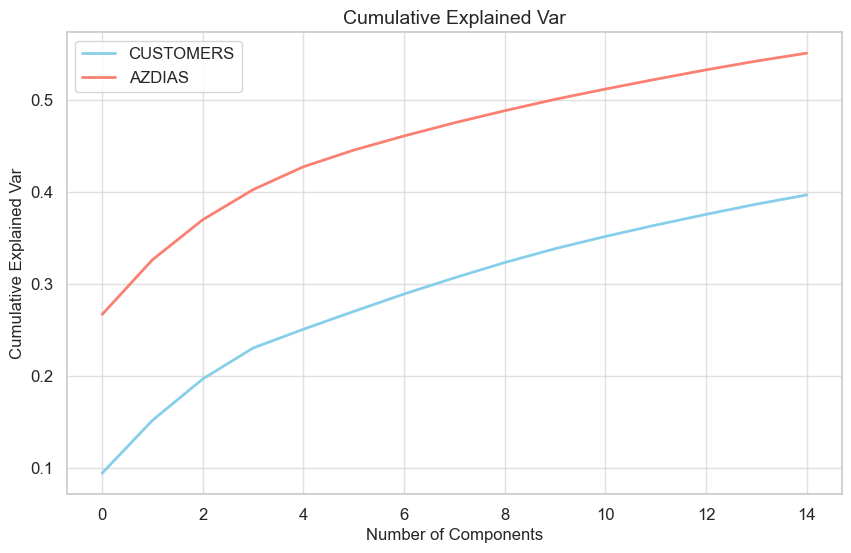

Cumulative Explained Var:
              CUSTOMERS    AZDIAS
Component 1    0.093962  0.266583
Component 2    0.151495  0.326073
Component 3    0.196470  0.369648
Component 4    0.230119  0.402324
Component 5    0.250510  0.427192
Component 6    0.269882  0.445278
Component 7    0.288826  0.460675
Component 8    0.306371  0.474988
Component 9    0.323039  0.488108
Component 10   0.338084  0.500504
Component 11   0.351389  0.511679
Component 12   0.363765  0.522307
Component 13   0.375401  0.532540
Component 14   0.386500  0.542114
Component 15   0.396512  0.550691


In [4]:
# PCA calc and visual
pca_results = {}
cumul_var = {}
for dataset in datasets:
    pca = PCA(n_components=15, random_state=random_seed)
    pca_transformed = pca.fit_transform(dfs[dataset])
    pca_results[dataset] = pca_transformed
    cumul_var[dataset.upper()] = np.cumsum(pca.explained_variance_ratio_)

# Create DataFrame to display cumulative variance as a list
cumul_var_df = pd.DataFrame(cumul_var, index=[f"Component {i + 1}" for i in range(15)])

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
for dataset in datasets:
    plt.plot(cumul_var[dataset.upper()], label=f"{dataset.upper()}")

# Add labels, titles, etc.
plt.title('Cumulative Explained Var', fontsize=14)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Var', fontsize=12)
plt.legend()
plt.show()

# Display the cumulative explained variance values
print("Cumulative Explained Var:")
print(cumul_var_df)

##### <span style="color:#5A8CC8">K-means cluster concentrations differ significantly between internal data (CUSTOMERS) and the German population more broadly (AZDIAS). Cluster 2 is much more common amongst customers, and cluster 0 amongst the population at large<span>

Cluster percentages for CUSTOMERS:
{0: 15.2, 1: 25.1, 2: 24.6, 3: 16.1, 4: 19.0}
Cluster percentages for AZDIAS:
{0: 24.3, 1: 21.7, 2: 13.3, 3: 22.4, 4: 18.2}


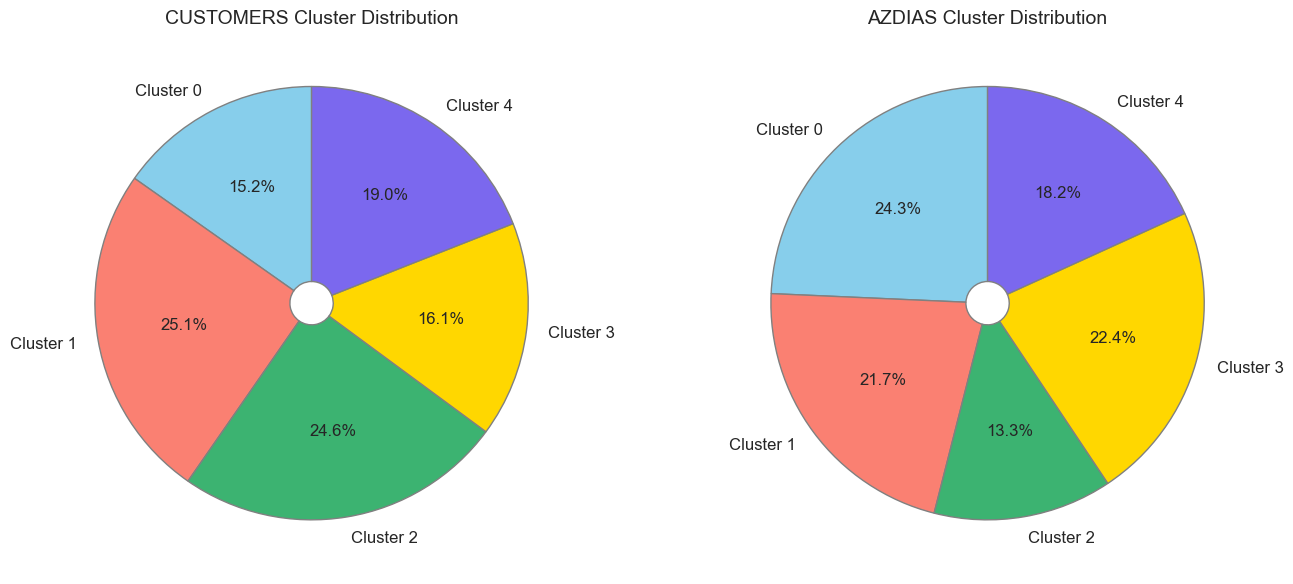

In [5]:
# K-means calc and visual
kmeans_clusters = {}
cluster_pct = {}
for dataset in datasets:
    kmeans = KMeans(n_clusters=5, random_state=random_seed, n_init='auto')
    clusters = kmeans.fit_predict(pca_results[dataset])
    kmeans_clusters[dataset] = clusters
    
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i, dataset in enumerate(datasets):
    # Calculate clusters as percentages of total data
    unique, counts = np.unique(kmeans_clusters[dataset], return_counts=True)
    percentages = counts / counts.sum() * 100
    cluster_pct[dataset] = percentages
    print(f"Cluster percentages for {dataset.upper()}:")
    print(dict(zip(unique, np.round(percentages,1))))

    # Plot pie chart
    axes[i].pie(percentages, labels=[f"Cluster {u}" for u in unique],autopct='%1.1f%%', startangle=90,wedgeprops=dict(width=0.9, edgecolor='gray'))
    axes[i].set_title(f"{dataset.upper()} Cluster Distribution", fontsize=14)

plt.tight_layout()
plt.show()


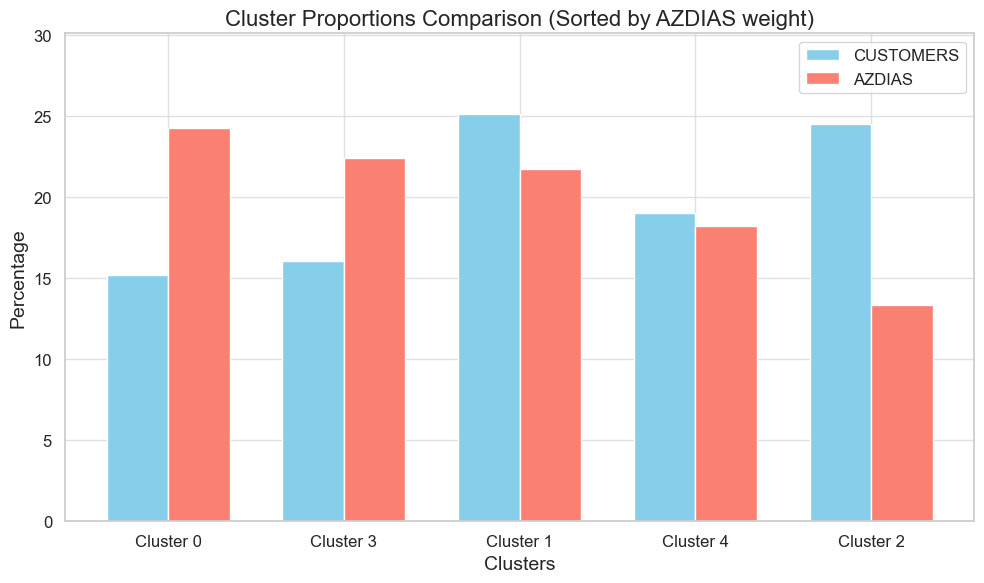

In [6]:
# Bar chart of kmeans cluster proportions within customers and azdias
clusters = [f"Cluster {i}" for i in range(5)]
customers_percentages = cluster_pct['customers']
azdias_percentages = cluster_pct['azdias']

# Order by azdias weights
sorted_indices = np.argsort(azdias_percentages)[::-1]
clusters_sorted = [f"Cluster {i}" for i in sorted_indices]
customers_sorted = customers_percentages[sorted_indices]
azdias_sorted = azdias_percentages[sorted_indices]

# Plot bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(clusters_sorted))
bar_width = 0.35

ax.bar(x - bar_width / 2, customers_sorted, bar_width, label="CUSTOMERS")
ax.bar(x + bar_width / 2, azdias_sorted, bar_width, label="AZDIAS")
ax.set_xlabel('Clusters')
ax.set_ylabel('Percentage')
ax.set_title('Cluster Proportions Comparison (Sorted by AZDIAS weight)')
ax.set_ylim(0, max(max(customers_sorted), max(azdias_sorted)) + 5)
ax.set_xticks(x)
ax.set_xticklabels(clusters_sorted)
ax.legend()

plt.tight_layout()
plt.show()

##### <span style="color:#5A8CC8">Let's try and infer whether principal components and k-means are telling us something similar. We can see that principal component loadings are a strong differentiator of clusters out ot the 4th or 5th principal copmonent, after which it tails off significantly. This suggests that there is notable differention here, and it can probably be captured with a fairly small number of model features<span>

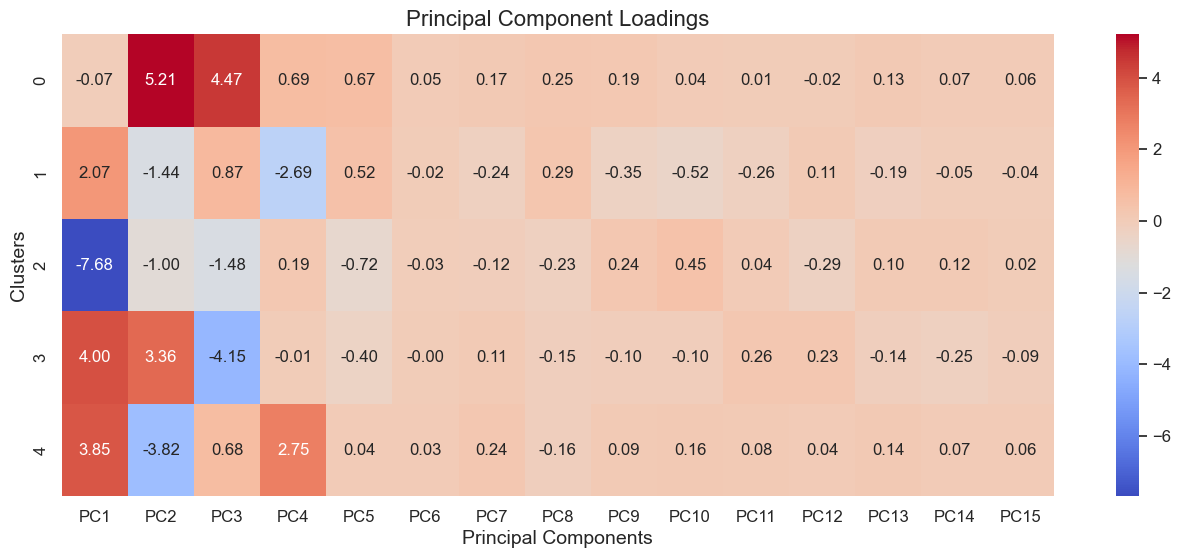

In [7]:
# Graph heatmap of cluster correlation with principalc omponents
pca_df = pd.DataFrame(pca_results['customers'], columns=[f'PC{i+1}' for i in range(15)])
pca_df['Cluster'] = kmeans_clusters['customers']

fig = plt.subplots(figsize=(16, 6))
cluster_means = pca_df.groupby('Cluster').mean()
sns.heatmap(cluster_means.iloc[:, :15], annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Principal Component Loadings")
plt.xlabel("Principal Components")
plt.ylabel("Clusters")
plt.show()

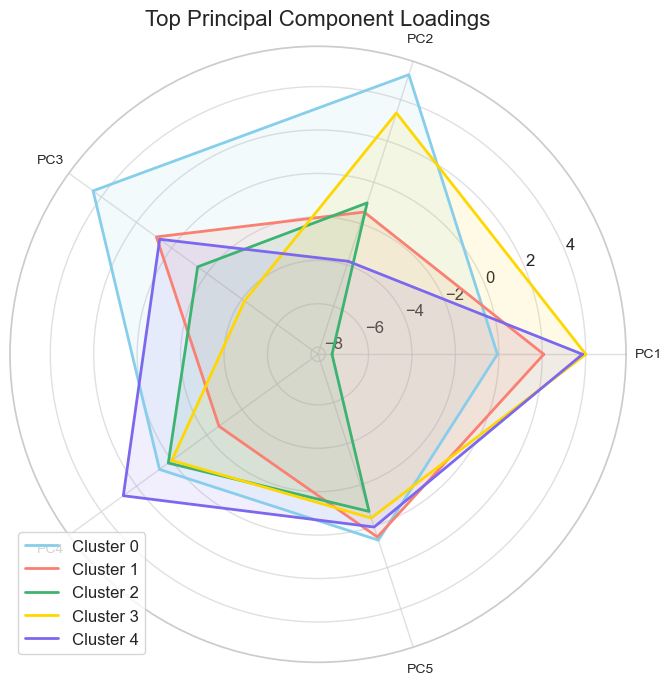

In [8]:
# Build radar chart of cluster means for key principal components
cluster_means = cluster_means.iloc[:, :5]
categories = cluster_means.columns

# Chart setup
num_clusters = cluster_means.shape[0]
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

# Plot it, baby
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, (index, row) in enumerate(cluster_means.iterrows()):
    values = row.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, label=f"Cluster {index}")
    ax.fill(angles, values, alpha=0.1)

ax.set_title("Top Principal Component Loadings")
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.legend()
plt.show()

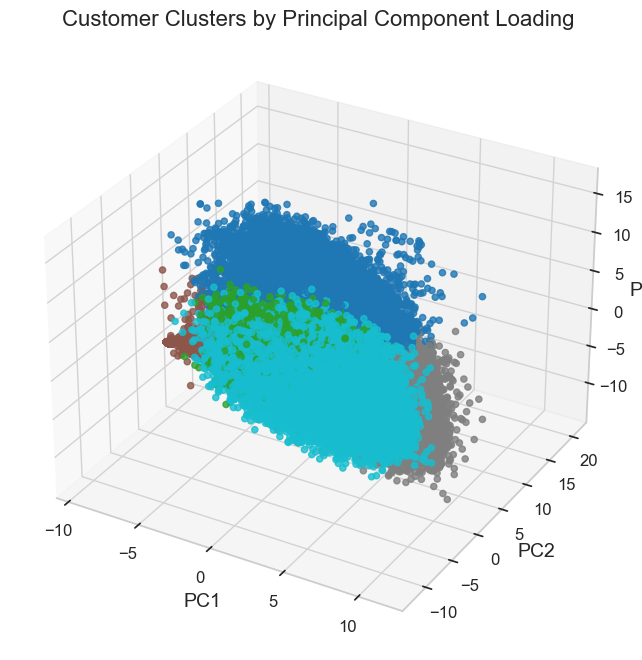

In [9]:
# 3D scatter plot of clusters by principal component loading (because it's fun)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='tab10', alpha=0.8)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Customer Clusters by Principal Component Loading')
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

##### <span style="color:#5A8CC8">Based on the customer profiles, a decision tree seems like a natural choice. We have a faily small number of discrete customer categories/underlying factors that drive the variance between customers. Let's see if a random forest can do a good job of predicting who will be a good customer<span>

In [ ]:
# Separate features and target
X = dfs['mailout_train'].drop(columns=['RESPONSE'])
y = dfs['mailout_train']['RESPONSE']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=random_seed, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")


Training set size: (30073, 457)
Validation set size: (12889, 457)


##### <span style="color:#5A8CC8">This verison of the random forest has some predictive power - we can see that the AUC is above 0.5, though at 0.61 it isn't particularly strong. We'll need to do some hyperparameter optimization and see if we can improve the model<span>

Non-Optimized Model:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     12729
         1.0       0.00      0.00      0.00       160

    accuracy                           0.99     12889
   macro avg       0.49      0.50      0.50     12889
weighted avg       0.98      0.99      0.98     12889

ROC-AUC Score: 0.6112553028517559


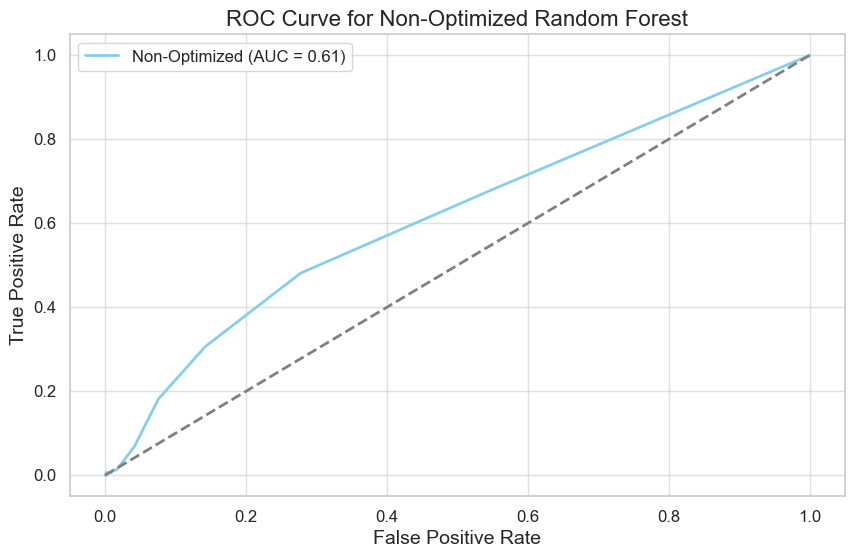

In [ ]:
# Non-optimized Random Forest
clf = RandomForestClassifier(random_state=random_seed, class_weight='balanced')
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_val)
y_prob = clf.predict_proba(X_val)[:, 1]

# Evaluate metrics
print("Non-Optimized Model:")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_val, y_prob))

# ROC curve for non-optimized model
fpr, tpr, _ = roc_curve(y_val, y_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Non-Optimized (AUC = {roc_auc_score(y_val, y_prob):.2f})', linestyle='-')

# Finalize ROC Curve plot
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve for Non-Optimized Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

##### <span style="color:#5A8CC8">Some earlier runs of this model with more estimators and max depth found the optimal model regularly settling at the smallest size within the given range. A smaller model is consistent with the smaller number of latent factors driving customer segments<span>

In [14]:
# Grid search for optimized model
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [3, 4, 5]
}
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='roc_auc', verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print("\nBest Parameters:", grid_search.best_params_)

# Optimized Random Forest
optimized_clf = RandomForestClassifier(random_state=random_seed, class_weight='balanced', **grid_search.best_params_)
optimized_clf.fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ..max_depth=5, min_samples_split=3, n_estimators=50; total time=   1.6s
[CV] END ..max_depth=5, min_samples_split=3, n_estimators=50; total time=   1.7s
[CV] END ..max_depth=5, min_samples_split=3, n_estimators=50; total time=   1.7s
[CV] END .max_depth=5, min_samples_split=3, n_estimators=100; total time=   2.9s
[CV] END .max_depth=5, min_samples_split=3, n_estimators=100; total time=   3.8s
[CV] END .max_depth=5, min_samples_split=3, n_estimators=100; total time=   6.0s
[CV] END ..max_depth=5, min_samples_split=4, n_estimators=50; total time=   2.5s
[CV] END ..max_depth=5, min_samples_split=4, n_estimators=50; total time=   1.9s
[CV] END ..max_depth=5, min_samples_split=4, n_estimators=50; total time=   2.0s
[CV] END .max_depth=5, min_samples_split=4, n_estimators=100; total time=   5.7s
[CV] END .max_depth=5, min_samples_split=4, n_estimators=100; total time=   3.9s
[CV] END .max_depth=5, min_samples_split=4, n_es

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=3, random_state=123)


Optimized Model:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.91     12729
         1.0       0.03      0.46      0.06       160

    accuracy                           0.83     12889
   macro avg       0.51      0.64      0.48     12889
weighted avg       0.98      0.83      0.89     12889

ROC-AUC Score: 0.7248993440175975


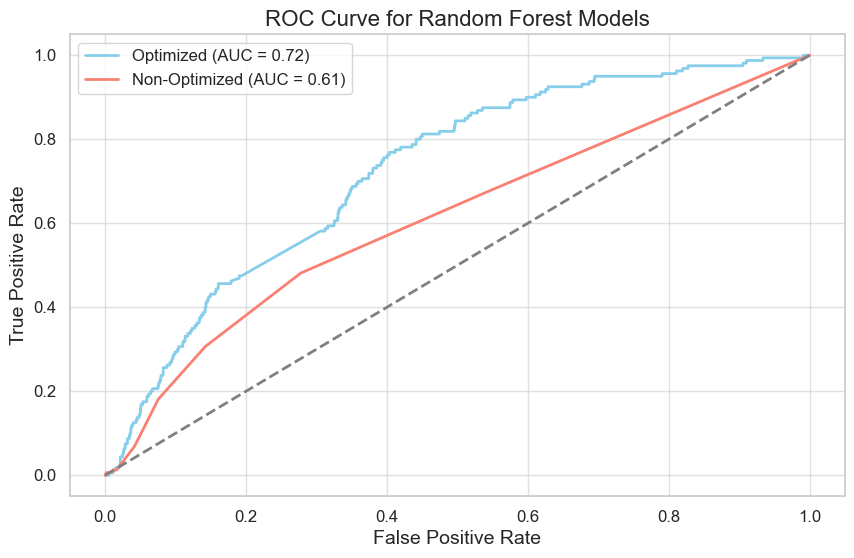

In [15]:
# Predictions for optimized model
y_optimized_prob = optimized_clf.predict_proba(X_val)[:, 1]
y_optimized_pred = optimized_clf.predict(X_val)

# Evaluate optimized metrics
print("\nOptimized Model:")
print("Classification Report:")
print(classification_report(y_val, y_optimized_pred))
print("ROC-AUC Score:", roc_auc_score(y_val, y_optimized_prob))

# ROC curve for optimized model
optimized_fpr, optimized_tpr, _ = roc_curve(y_val, y_optimized_prob)
plt.plot(optimized_fpr, optimized_tpr, label=f'Optimized (AUC = {roc_auc_score(y_val, y_optimized_prob):.2f})')
plt.plot(fpr, tpr, label=f'Non-Optimized (AUC = {roc_auc_score(y_val, y_prob):.2f})', linestyle='-')

# Finalize ROC Curve plot
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve for Random Forest Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [16]:
# Predict probz for 'mailout_test'
X_test = dfs['mailout_test']  # Test data without 'RESPONSE'
test_probs = optimized_clf.predict_proba(X_test)[:, 1]

# Create dataframe of predictions
submission_df = pd.DataFrame({
    'Index': X_test.index,  
    'RESPONSE': test_probs
})

# Save predictions to a CSV file
submission_df.to_csv('mailout_test_preds.csv', index=False)
print("Predictions saved to 'mailout_test_preds.csv'")

Predictions saved to 'mailout_test_preds.csv'
